In [155]:
#Import the necessary data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [156]:
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


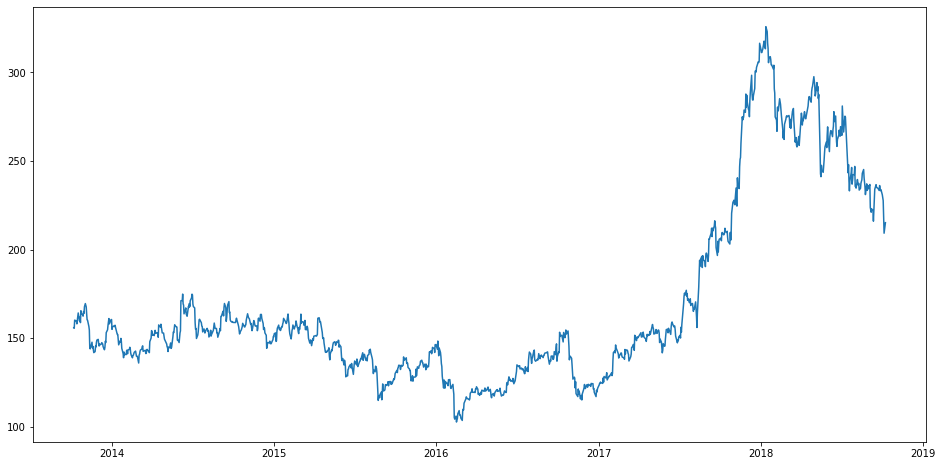

In [157]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [158]:
n = 10
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)-n),columns=['Date', 'ROC'])
for i in range(n, len(data)):
    new_dataset["Date"][i-n]=data["Date"][i]
    new_dataset["ROC"][i-n]=(data["Close"][i] - data["Close"][i-n])/data["Close"][i-n]*100
new_dataset.head()


,Date,ROC
0,2013-10-23 00:00:00,1.893453
1,2013-10-24 00:00:00,6.364513
2,2013-10-25 00:00:00,2.310334
3,2013-10-28 00:00:00,1.999375
4,2013-10-29 00:00:00,1.85011


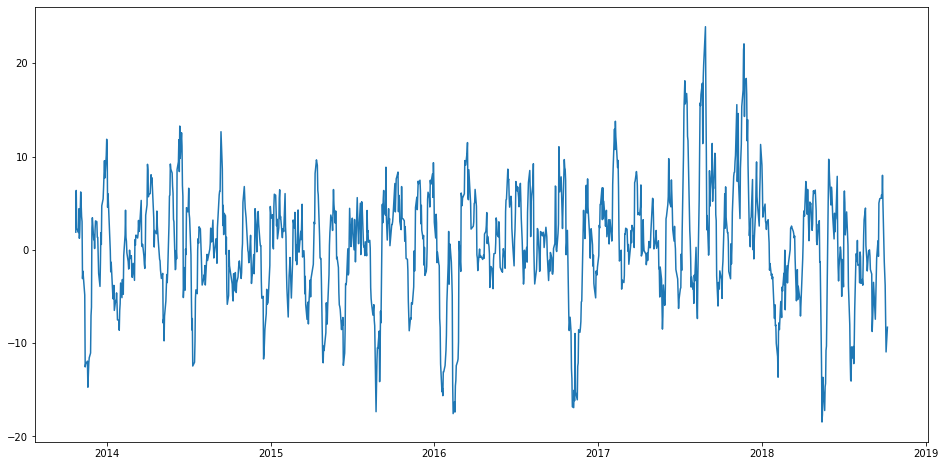

In [159]:
new_dataset["Date"]=pd.to_datetime(new_dataset.Date,format="%Y-%m-%d")
new_dataset.index=new_dataset['Date']

plt.figure(figsize=(16,8))
plt.plot(new_dataset["ROC"],label='Price range of change history')

In [160]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)
final_dataset = new_dataset.values

train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [161]:
#Initializing our recurrent neural network
rnn = Sequential()

In [162]:
#Adding our first LSTM layer
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_train_data.shape[1], 1)))

In [163]:
#Perform some dropout regularization
rnn.add(Dropout(0.2))

In [164]:
#Adding three more LSTM layers with dropout regularization
for i in [True, True, False]:
    rnn.add(LSTM(units = 45, return_sequences = i))
    rnn.add(Dropout(0.2))

In [165]:
#Adding our output layer
rnn.add(Dense(units = 1))

In [166]:
#Compiling the recurrent neural network
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [167]:
#Training the recurrent neural network
rnn.fit(x_train_data, y_train_data, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 [==============================] - 10s 84ms/step - loss: 0.0427
Epoch 2/100
29/29 [==============================] - 2s 86ms/step - loss: 0.0220
Epoch 3/100
29/29 [==============================] - 2s 83ms/step - loss: 0.0213
Epoch 4/100
29/29 [==============================] - 2s 82ms/step - loss: 0.0223
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 0.0216
Epoch 6/100
29/29 [==============================] - 3s 87ms/step - loss: 0.0206
Epoch 7/100
29/29 [==============================] - 2s 86ms/step - loss: 0.0202
Epoch 8/100
29/29 [==============================] - 3s 90ms/step - loss: 0.0198
Epoch 9/100
29/29 [==============================] - 3s 89ms/step - loss: 0.0197
Epoch 10/100
29/29 [==============================] - 3s 96ms/step - loss: 0.0181
Epoch 11/100
29/29 [==============================] - 3s 89ms/step - loss: 0.0176
Epoch 12/100
29/29 [==============================] - 3s 98ms/step - loss: 0.0165
Epoch 13/100
29/29 [====

In [168]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [169]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_ROC=rnn.predict(X_test)
predicted_ROC=scaler.inverse_transform(predicted_ROC)

In [170]:
rnn.save("model_RNN_ROC.h5")

C:\Users\buith\AppData\Local\Temp/ipykernel_16812/2022177623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_ROC


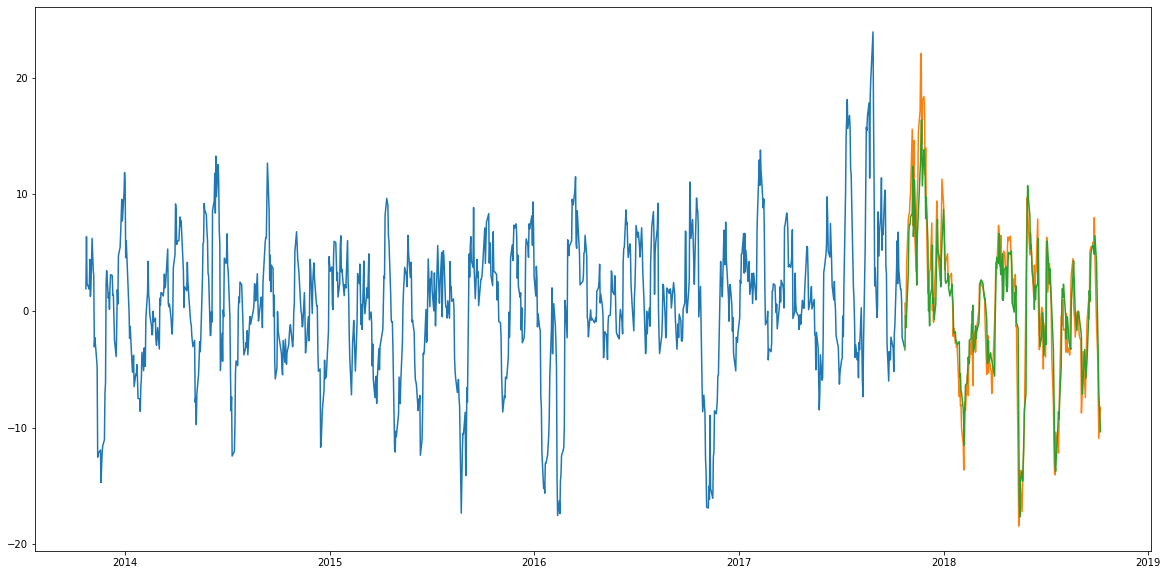

In [171]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_ROC
plt.plot(train_data["ROC"])
plt.plot(valid_data[['ROC',"Predictions"]])